# Introduction


It will be already three years from the start of the covid-19 pandemic, but situation is still unpredictable. People all around the world start traveling again, but there are different restrictions and rules due to covid-19 in different countries. So you'll never know, what and when you can get sick and how to deal with it abroad. So better be prepared. 

Tour & Travels Company wants to offer travel insurance package with covid-19 coverage to some and later maybe to all of their customers.
The Company requires to know (predict) which of their customers would have interest to buy this insurance package. It can be predicted based on Companies database history. In 2019 this type of insurance was offered to some segment of the customers and Company has extracted the Performance/Sales of the travel insurance package with coverage from covid-19 during that period. Company need a tool, which could 'forsee' if certain customer could be interested in the travel insurance package with covid-19 coverage and in that case to offer it him/her. After some testing time Company wants to gather more information (about claims also) and with this data make some deeper predictions, is it profitable to offer this package to all of the clients, or only to some groups of them.
So it is the first stage of this research, to find basic patterns and make a tool for basic predictions of interest in covid-19 insurance.

## 1.1. Data set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats.distributions as dist
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.genmod import families
# from skimpy import clean_columns
from math import ceil
import matplotlib as mpl
# from functions import my_functions as mf
from IPython.display import Image
from warnings import filterwarnings
filterwarnings(action='ignore')
%matplotlib inline   
%load_ext blackcellmagic

In [2]:
pd.set_option('float_format', '{:.2f}'.format)

In [3]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [4]:
sns.set_theme(style='darkgrid')

In [5]:
df = pd.read_csv('TravelInsurancePrediction.csv', index_col=0)

In [6]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## 1.2. Data cleaning 

* Changing te column names.

In [7]:
insurance_df = clean_columns(df)
insurance_df.columns.tolist()

9 column names have been cleaned

['age',
 'employment_type',
 'graduate_or_not',
 'annual_income',
 'family_members',
 'chronic_diseases',
 'frequent_flyer',
 'ever_travelled_abroad',
 'travel_insurance']

* Changing column values into lower case.

In [8]:
insurance_df = insurance_df.applymap(lambda s: s.lower() if type(s) == str else s)

* Temporarily for the purpose of easier understanding in the EDA, let's change the values: 1 into 'yes' - and 0 into 'no' - columns: 'travel_insurance', 'chronic_diseases'.

In [9]:
insurance_df[['chronic_diseases','travel_insurance']] = insurance_df[['chronic_diseases','travel_insurance']].replace({1: 'yes', 0 : 'no'})

In [10]:
insurance_df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance
0,31,government sector,yes,400000,6,yes,no,no,no
1,31,private sector/self employed,yes,1250000,7,no,no,no,no
2,34,private sector/self employed,yes,500000,4,yes,no,no,yes
3,28,private sector/self employed,yes,700000,3,yes,no,no,no
4,28,private sector/self employed,yes,700000,8,yes,yes,no,no


* Checking for null values.

In [11]:
insurance_df.isna().sum()

age                      0
employment_type          0
graduate_or_not          0
annual_income            0
family_members           0
chronic_diseases         0
frequent_flyer           0
ever_travelled_abroad    0
travel_insurance         0
dtype: int64

So, luckily there are no null values at all. Nothing to clean. 

* Checking for duplicates.

In [12]:
insurance_df.duplicated().sum()

738

So there are lot's of duplicates. But as most of the values in this data set are boolean (yes/no answers), that probably could be the case of many identic instances. But I'l have this in mind.

# 1.2.  Description of all features in the data set.

**Predictors (independent feature) variables:**

1.  **age** - numerical continuous: variable: age of the customer.
2. **employment_type** - categorical variable: the sector in which customer is employed. Possible outcomes:
- government sector - 0;
- private sector/self/employed - 1.
3. **graduate_or_not** - boolean: yes/no: whether the customer is college graduate or not.
4. **annual_income** - numerical continuous variable: the yearly income of the customer in Indian Rupees: rounded to nearest 50 thousand rupees.
5. **family_members** - numerical discrete variable: number of members in customer's family.
6. **chronic_disease** - boolean: 1-yes/0-no: whether the customer suffers from any major disease or conditions like diabetes/high BP or asthma, etc. - increases the possibility of heavier forms of Covid-19.
7. **frequent_flyer** - boolean: yes/no: derived data based on customer's history of booking air tickets on at least 4 different instances in the last 2 years: 2017-2019.
8. **ever_travelled_abroad** - boolean: yes/no: has the customer ever travelled to a foreign country (not necessarily using the company's services).


**Target (dependent feature) variable:**

9. **travel_insurance** - boolean:0-no/1-yes: did the customer buy travel insurance package during introductory offering held in the year 2019.

# 2. EDA

## 2.1. Target variable - travel_insurance. 

How many persons got travel insurance in this dataset?

In [13]:
len(insurance_df.travel_insurance)

1987

So total number of observations is 1987. From them:

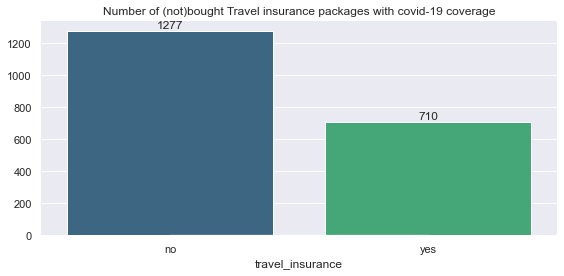

In [14]:
mf.plot_countplot(
    insurance_df,
    "travel_insurance",
    None,
    "Number of (not)bought Travel insurance packages with covid-19 coverage",
)

1277 people did not buy this package of travel insurance and 710 did. Now let's see all independent features and what relationship between each of them and the target variable could be identified. So data set is imbalanced. We have more outcome of non purchased travel insurance packages. Let's see how many duplicates are there, as those for sure can be removed.

In [17]:
insurance_df[insurance_df['travel_insurance'] == 'no'].duplicated().sum()

511

So these values for sure could be removed in the feature preprocessing stage.

## 2.2. Independent features
### 2.2.1. **age**

In [15]:
insurance_df.age.describe()

count   1987.00
mean      29.65
std        2.91
min       25.00
25%       28.00
50%       29.00
75%       32.00
max       35.00
Name: age, dtype: float64

So we see that, travel insurance with included covid-19 package was offered to people in age between 25 and 35, mostly to almost thirty yer olds.

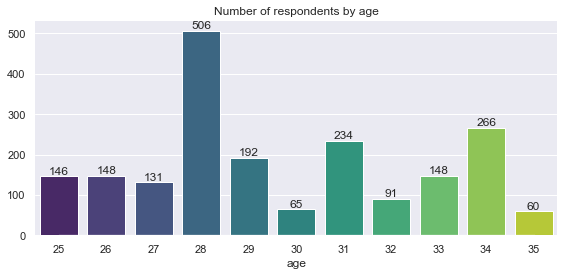

In [16]:
mf.plot_countplot(insurance_df, "age", None, "Number of respondents by age")

The count plot confirms that mostly this covid-19 insurance package was offered to people of age 28 (506 times), the next largest group were people of age 34 years old - 266 times and 31 years old - 234 times. In total the range of age is very narrow and it doesn't cover older people, which are in the risk group of more complicated covid-19 forms and could be more interested in this kind of insurance.

In [18]:
age_insurance = pd.DataFrame(
    {
        'number_by_age': insurance_df.groupby(['age'])[
            'travel_insurance'
        ].value_counts(),
        'percentage': insurance_df.groupby(['age'])['travel_insurance'].value_counts(
            normalize=True
        )
        * 100,
    }
).reset_index()
age_insurance['travel_insurance'] = age_insurance['travel_insurance'].replace(
    {1: 'yes', 0: 'no'}
)
age_insurance['percentage'] = age_insurance['percentage'].round(2)
age_insurance

,age,travel_insurance,number_by_age,percentage
0,25,yes,92,63.01
1,25,no,54,36.99
2,26,no,74,50.00
3,26,yes,74,50.00
4,27,no,104,79.39
5,27,yes,27,20.61
6,28,no,401,79.25
7,28,yes,105,20.75
8,29,no,141,73.44
9,29,yes,51,26.56


In [19]:
mf.plot_line_plot_plotly(age_insurance, 'age', 'number_by_age', 'travel_insurance', 'Number of (not)purchased travel insurance by age')

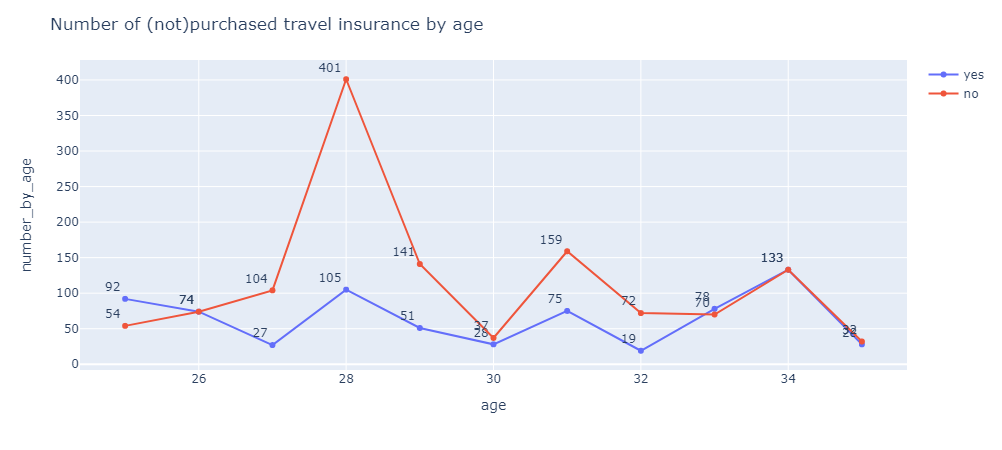

In [22]:
# If plotly doesn't show a chart, here it is.
Image(filename='png\line_chart_by_age.png')

Despite the fact, that the largest group of people offered with this insurance was of age 28 (in total 506, bought only 105), the largest number of people that actually bought this insurance was in the age of 34 - bought 133. 

In [20]:
# data preparation for plotting
age_insurance_yes = age_insurance[age_insurance['travel_insurance'] == 'yes'][
    ['age', 'percentage']
]
age_insurance_no = age_insurance[age_insurance['travel_insurance'] == 'no'][
    ['age', 'percentage']
]
age_insurance_perc = pd.merge(
    age_insurance_yes, age_insurance_no, on='age', suffixes=('_yes', '_no')
)

In [21]:
mf.plot_stacked_barchart_plotly(
    age_insurance_perc,
    'age',
    ['percentage_yes', 'percentage_no'],
    'Percentage of (not)purchased insurances by age groups',
    'Bought insurance:',
)

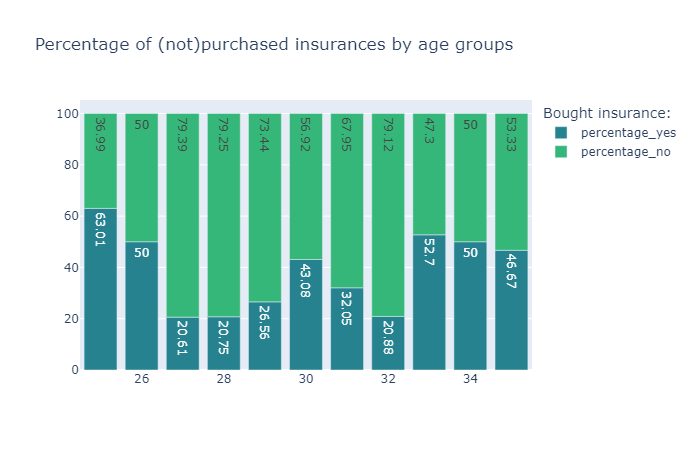

In [2]:
# If plotly doesn't show a chart, here it is.
Image(filename='png\\age_groups.png')

By percentage we see that most likely to buy the covid-19 insurance were people of age 25, 26, 33, 34. But all in all this dataset is quite small and the total amount of covid-19 insurance was offered to quite small group of people by age and it is hard to see some patterns here. Some younger people and people over 33 by this data are tend to buy more than the others.

### 2.2.2. **employment_type**

In [25]:
insurance_df.employment_type.value_counts()

private sector/self employed    1417
government sector                570
Name: employment_type, dtype: int64

As we see the majority of people were employed in private sector (self employed). Let's see how travel insurance buyers and not variates according to this feature.

In [22]:
mf.make_crosstab_number(insurance_df, 'employment_type', 'travel_insurance')

travel_insurance,no,yes
employment_type,,
government sector,430,140
private sector/self employed,847,570


Let's see the percentage.

In [23]:
mf.make_crosstab_percent(insurance_df, 'employment_type', 'travel_insurance')

travel_insurance,no,yes
employment_type,,
government sector,75.44,24.56
private sector/self employed,59.77,40.23


It seems that travel insurance with covid-19 coverage was more often offered to the people, who tend to work in private sector and over 40 percent of them bought this insurance. While working in the government sector only 25 percent bought this insurance. It could be an indication, that people, working in private sector, are more likely to buy travel insurance. Let's see is the difference of these proportions statistically significant.

* **Inferential statistical analysis:**

In [24]:
table1 = pd.DataFrame(
    {
        'with_insurance': [140/570, 570/1417],
        'number_of_people': [570, 1417],
        'number_of_insurances': [140, 570],
    },
    index=['government_sector', 'private_sector'],
)
table1

,with_insurance,number_of_people,number_of_insurances
government_sector,0.25,570,140
private_sector,0.40,1417,570


**Research question:**
Is the difference in proportions of insurance buyers, working in government/private sector, statistically significant?

**Population** All people, who were interviewed.

People, who claimed, to work in government sector = 570.

People, who claimed, to work in private sector = 1417.

**Parameter of interest:** 
Difference in population proportions: (p(1) - p(2)) -> 0.25-0.40 = -0.15
                                      

**Power of the test:** ($1 - \beta$) - 0.8 

**Significance level**: 0.05

**Null Hypothesis:** p1 - p2 = 0  (there is no difference)

**Alternative Hypothesis:** p1 - p2 < 0

One tail testing, the difference is < 0.

**Assumptions**:
1. Our samples are independent from each other (taken from different people, different time).

* Preliminary power test analysis, to get the needed sample size to avoid p-hacking.

In [25]:
effect_size = sms.proportion_effectsize(
        0.25, 0.40
)

required_n = sms.NormalIndPower().solve_power(
    effect_size, power=0.8, alpha=0.05, ratio=1
)  
required_n = ceil(required_n)
print(
    f'Required sample size:{required_n}'
)

Required sample size:152


I have a much larger sample size, so I think p-hacking should be avoided.

* **Calculations**

In [26]:
p_comb = (298+412)/1987  # the mean of all insurances
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / 570 + 1 / 1417))

# Calculate the test statistic and its p-value
test_stat = (0.25-0.40) / se
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))
print(f'T-statistics: {test_stat}, p-value: {pvalue}')

T-statistics: -6.310850942337212, p-value: 2.7750537292478084e-10


The difference of the proportions of insurance buyers among people, who work in government and private sector is very large: - 0.15. The aim was to check is this difference statistically significant, or maybe made by a chance. 
From this observed data we got, that the T -statistics in the difference of two proportions is large -6.31, so our observed difference in sample proportions is -6.31 estimated standard errors below our hypothesized mean (0) of equal population proportions. Based on our sample and our p-value is 2.7750537292478084e-10, that is almost equal to 0 and is smaller than our set alpha value of 0.05, we have enough evidence to reject the null hypothesis. 
In this case, we conclude that there is significant difference between the population proportions of insurance buyers among people, who work in government and private sector. People from private sector tend to buy more travel insurances. 

Let's check the Confidence interval.

**Confidence intervals**

1. Confidence level of 95%.
2. Significant level alpha = 0.05

In [27]:
table1

,with_insurance,number_of_people,number_of_insurances
government_sector,0.25,570,140
private_sector,0.40,1417,570


In [28]:
se_government = np.sqrt(0.25* (1 - 0.25) / 570)
se_private = np.sqrt(0.40 * (1 - 0.40) / 1417)

se_diff = np.sqrt(se_government**2 + se_private**2)

lcb = -0.15- 2*se_diff
ucb = -0.15 + 2*se_diff
print(f'CI in proportion of insurances among people, who work in government and private sector: {lcb, ucb}')

CI in proportion of insurances among people, who work in government and private sector: (-0.19464613223616267, -0.10535386776383732)


The 95% confidence interval above shows us that any value for the difference of population proportions (between insurance buyers, working in government and private sectors) is lying between -0.19 and -0.10, this is consistent with the observed data, and our estimated difference was -0.15, which is in that range. 0 in not in this range, so the null hypothesis, that the difference between proportions could be 0 was rejected correctly. It is confirmed, that there tend to be from 10 to 19 percent more insurance buyers in private sector that in government sector employees.

### 2.2.3. **graduate_or_not**

In [29]:
insurance_df.graduate_or_not.value_counts()

yes    1692
no      295
Name: graduate_or_not, dtype: int64

The majority of people were graduates of the college. Let's see their opinion on travel insurance from covid - 19.

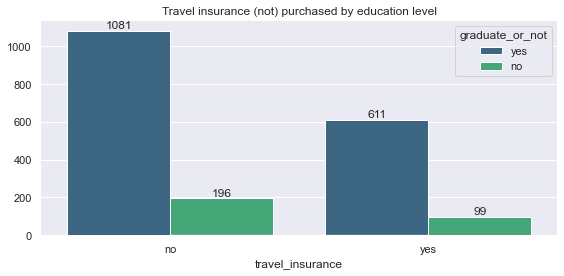

In [32]:
mf.plot_countplot(
    insurance_df,
    "travel_insurance",
    "graduate_or_not",
    "Travel insurance (not) purchased by education level",
)

In [34]:
mf.make_crosstab_percent(insurance_df, 'graduate_or_not', 'travel_insurance')

travel_insurance,no,yes
graduate_or_not,,
no,66.44,33.56
yes,63.89,36.11


Actually we see that almost the same percentage of graduates and non graduates tend to buy this insurance - about 34-36 percent, the difference is only couple of percent. But the majority of people, who were offered by this insurance - were college graduates (1692 out of 1987). All in all it doesn't seem  that education level could be a very could indicator for predicting.

### 2.2.4. **annual_income**

In [35]:
insurance_df.annual_income.describe()

count      1987.00
mean     932762.96
std      376855.68
min      300000.00
25%      600000.00
50%      900000.00
75%     1250000.00
max     1800000.00
Name: annual_income, dtype: float64

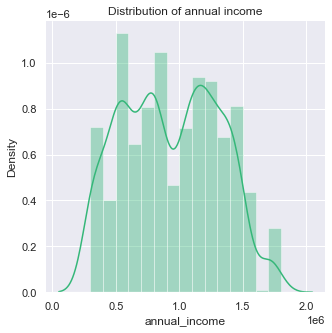

In [36]:
plt.figure(figsize=(5,5))
sns.distplot(insurance_df.annual_income, color='#35b779')
plt.title('Distribution of annual income')
sns.despine(trim=True, left=True);

In [37]:
insurance_df.annual_income.value_counts().sort_index(ascending = False).head()

1800000     4
1750000    15
1700000    37
1650000     2
1550000     5
Name: annual_income, dtype: int64

It seems, that all values are quite possible and the largest sum for annual income - 1800 000 rupees is given four times, the closest 'neighbor' is not so far - 1750 000 rupees, so I don't think that this value is an outlier, which should be fixed.

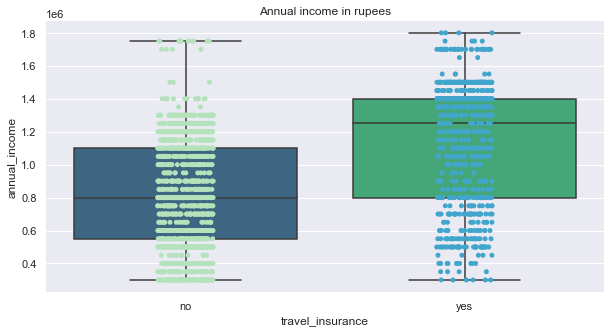

In [39]:
mf.plot_box_stripplot(
    insurance_df, "travel_insurance", "annual_income", "Annual income in rupees"
)

We can see that people, who tend to buy travel insurance with covid-19 protection have much higher mean of the annual income, the difference is more than 400 000 rupees, also the 25 and 75 percentiles of the annual income are a lot higher. Let's see is this difference in means statistically significant.

* **Inferential statistical analysis:**

**Research question**
When considering people, who had bought travel insurance and who hadn't, is the difference in means of annual income in these two groups statistically significant? (hypothesis test comparing means of two independent populations)

**Population**: people, who were interviewed, after offering them to buy travel insurance.

**Population subgroups**: 
1. people, who have bought travel insurance;

2. people who haven't bought travel insurance.

**Parameter of Interest**: difference in population subgroups mean annual income (in rupees).

**Explanation**:
$\mu$ (1)- mean annual income of people, who had bought travel insurance

$\mu$ (2) - mean annual income of people, who hadn't bought travel insurance

**Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention.

**Significance level**: 0.05

**Null Hypothesis:** H(O): $\mu$ (1) -$\mu$ (2) = 0

**Alternative Hypothesis:** $\mu$ (1) - $\mu$ (2) > 0

This will be a *one tail* testing.


In [40]:
with_insurance = pd.DataFrame(insurance_df[insurance_df['travel_insurance'] == 'yes']['annual_income'])
with_insurance.head()

,annual_income
2,500000
7,1350000
8,1450000
11,1400000
12,850000


In [41]:
len(with_insurance)

710

In [42]:
without_insurance = pd.DataFrame(insurance_df[insurance_df['travel_insurance'] == 'no']['annual_income'])
without_insurance.head()

,annual_income
0,400000
1,1250000
3,700000
4,700000
5,1150000


In [43]:
len(without_insurance)

1277

* Checking the normality of distributions.

<Figure size 720x720 with 0 Axes>

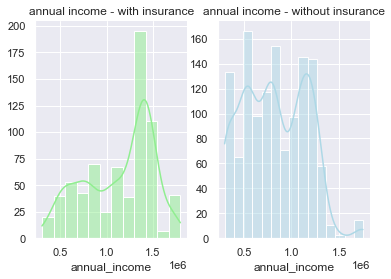

In [44]:
plt.figure(figsize=(10, 10))
f, axes = plt.subplots(1, 2)

with_insur_hist = sns.histplot(data= with_insurance, x='annual_income', kde=True, color='lightgreen', ax=axes[0])
with_insur_hist.set(ylabel='')
with_insur_hist.set(xlabel='annual_income')
with_insur_hist.set_title(f'annual income - with insurance')

without_insur_hist = sns.histplot(data=without_insurance, x='annual_income', kde=True, color='lightblue', ax=axes[1])
without_insur_hist.set(ylabel='')
without_insur_hist.set(xlabel='annual_income')
without_insur_hist.set_title(f'annual income - without insurance')

sns.despine(right=True, left=False)
plt.show()


In [45]:
# Tables to use.
table1 = pd.DataFrame({'n': [len(with_insurance),len(without_insurance)],
'mean': [with_insurance['annual_income'].mean(),without_insurance['annual_income'].mean()],
'std': [with_insurance['annual_income'].std(), without_insurance['annual_income'].std()]}, index=(['with_insurance', 'without_insurance']))
table1

,n,mean,std
with_insurance,710,1133239.44,374844.68
without_insurance,1277,821299.92,328898.90


**Assumptions**:
1. I assume that those are simple random samples. Samples are independent one from each other.
2. The distributions of annual income of both subpopulations doesn't seem normal, both are skewed to the different sides, but there are almost 2000 observations per both data sets, so accounting on Central limit theorem, I still proceed the t-testing.
3. I assume that the standard deviations of these two populations are quite similar, according to very large total numbers of annual income. That's why I use the pooled approach.

* Power analysis, as sample sizes differ.

In [46]:
# Difference in two means:

diff_means_income = table1.iloc[0]['mean'] - table1.iloc[1]['mean']
diff_means_income

311939.51492825395

In [47]:
# estimated standard deviation

est_std_income = np.sqrt(
    (table1.iloc[0]['std']**2 + table1.iloc[1]['std']**2)/2
    )
est_std_income

352620.9130070868

In [48]:
# effect size

effect_size_income = diff_means_income/est_std_income

In [49]:
# required sample sizes

required_n = sms.NormalIndPower().solve_power(
    effect_size_income,
    power=0.8, 
    alpha=0.05, 
    ratio=1, 
    alternative='larger'
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

16


So I have larger sample sizes, p-hacking should be avoided.

In [50]:
# t-test pooled approach

statistics, p_value = stats.ttest_ind(
    with_insurance['annual_income'],
    without_insurance['annual_income'],
    equal_var=True, alternative='greater',
)
print(f"T-statistic: {statistics}, p-value: {p_value}")

T-statistic: 19.257785253687544, p-value: 3.317508880176645e-76


To conclude, the t - statistics:  19.25, so the difference between sample means of annual income, are above the hypothesized 0 value by more than 19 estimated standard errors, thats a lot. The p-value is so small, that almost equal to zero and is definitely smaller than the alpha of 0.05. So, there's enough evidence to reject the NULL hypothesis. When considering people, who bought travel insurance, interviewed in this data set, their mean of annual income is significantly higher than the mean of annual income of people, who did not buy travel insurance.

* Confidence interval of the difference between two means of annual income in the group of people with travel insurance and without.
1. Confidence level of 95%.
2. Significant level alpha = 0.05
3. Pooled approach.

In [51]:
sem_with_insurance = with_insurance['annual_income'].std() / np.sqrt(
    len(with_insurance)
)
sem_without_insurance = without_insurance['annual_income'].std() / np.sqrt(
    len(without_insurance)
)
(sem_with_insurance, sem_without_insurance)

(14067.670065052296, 9203.795667071314)

In [52]:
sem_diff_income = np.sqrt(sem_with_insurance ** 2 + sem_without_insurance ** 2)
sem_diff_income

16810.98437749465

In [53]:
lower_conf_bound_income = diff_means_income - 1.96 * sem_diff_income
upper_conf_bound_income= diff_means_income + 1.96 * sem_diff_income
(lower_conf_bound_income, upper_conf_bound_income)
print(
    f'Confidence interval for the difference between the means of annual income of people with insurance and without:\
    {lower_conf_bound_income}, {upper_conf_bound_income}')

Confidence interval for the difference between the means of annual income of people with insurance and without:    278989.98554836446, 344889.04430814344


With 95% confidence, the difference in means of annual income in these groups of people is estimated to be between 278989.98 and 344889.04 rupees. That means, that our NULL hypothesis with the difference of these two measured population mean to be 0, do not fall into this interval, so to reject the null hypothesis was the right decision. The counted difference of sample means 311939.51, falls into this interval and is a reasonable value. So there is a significant difference in these two means.

Conclusion: annual income could be one of the great predictors for travel insurance purchasing predictions, increasing annual income increases probability that a person will buy the insurance.

### 2.2.5. **family_members**

In [54]:
insurance_df.family_members.value_counts()

4    505
5    426
3    377
6    294
7    178
2     93
8     59
9     55
Name: family_members, dtype: int64

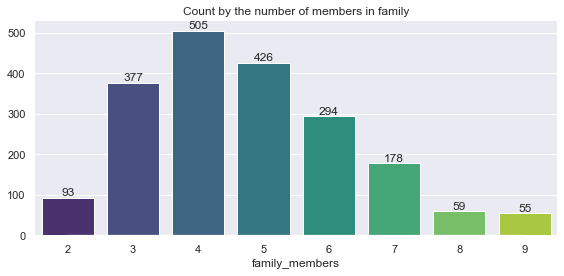

In [56]:
mf.plot_countplot(
    insurance_df, "family_members", None, "Count by the number of members in family"
)

In [57]:
family_perc = mf.make_crosstab_percent(insurance_df, 'family_members', 'travel_insurance')
family_perc.T

family_members,2,3,4,5,6,7,8,9
travel_insurance,,,,,,,,
no,70.97,64.19,68.32,69.25,56.12,54.49,64.41,52.73
yes,29.03,35.81,31.68,30.75,43.88,45.51,35.59,47.27


In [59]:
family_reseted = family_perc.reset_index()
mf.plot_stacked_barchart_plotly(
    family_reseted,
    "family_members",
    ["no", "yes"],
    "Percentage of (not) purchased travel insurances by the number of family member",
    "Purchased insurance or not",
)

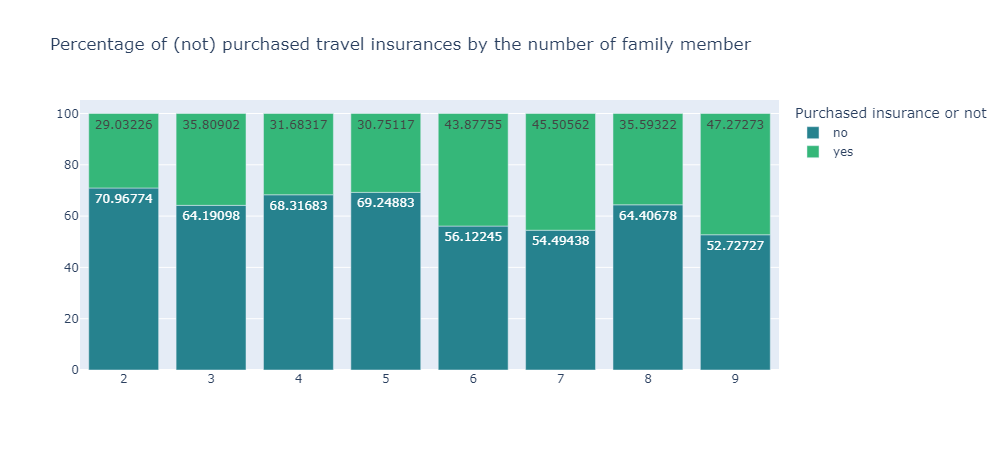

In [58]:
# If plotly doesn't show a chart, here it is.
Image(filename='png\stacked_family_members.png')

So we see, that respondents have from two to nine members in their families. The largest category was - 4, then 3 and 5 members. From the bar chart above we see that by percentage more travel insurance polices were bought by people with larger families (from 6 to 9), where the percentage of purchased insurances varies from 43 to 47 percent, except families of 7 people (37 percent). In the largest category (families of 4 members) - almost 32 percent out of 505 people bought this insurance. But no really strong patterns can be found by this category.

* In this part I want to add one more feature - annual_income_per person, as it can be very different in small and large families and could be a new indicator if a person even can afford to buy insurance.

In [60]:
insurance_df['annual_income_per_person'] = insurance_df['annual_income']/insurance_df['family_members']
insurance_df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,annual_income_per_person
0,31,government sector,yes,400000,6,yes,no,no,no,66666.67
1,31,private sector/self employed,yes,1250000,7,no,no,no,no,178571.43
2,34,private sector/self employed,yes,500000,4,yes,no,no,yes,125000.00
3,28,private sector/self employed,yes,700000,3,yes,no,no,no,233333.33
4,28,private sector/self employed,yes,700000,8,yes,yes,no,no,87500.00


### 2.2.6. **chronic_diseases**

In [61]:
len(insurance_df)

1987

In [62]:
insurance_df.chronic_diseases.value_counts()

no     1435
yes     552
Name: chronic_diseases, dtype: int64

In the majority (1435 out of 1987) of observations in this data set people have specified, that they have no chronic diseases. Let's see which group was tend to buy insurances more.

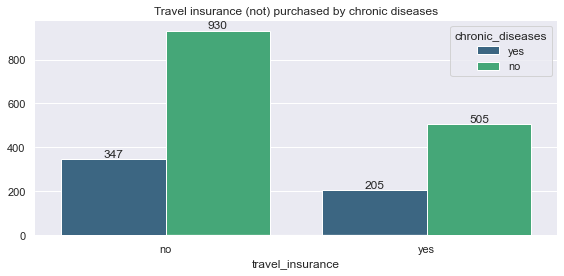

In [63]:
mf.plot_countplot(
    insurance_df,
    'travel_insurance',
    'chronic_diseases',
    'Travel insurance (not) purchased by chronic diseases',
)

In [65]:
diseases_perc = mf.make_crosstab_percent(
    insurance_df, 'chronic_diseases', 'travel_insurance'
)
diseases_perc

travel_insurance,no,yes
chronic_diseases,,
no,64.81,35.19
yes,62.86,37.14


It is quite surprising, but people with chronic diseases according to this bar chart and cross table doesn't look to be more interested in travel insurance with coverage from covid-19. There is only 2 percent increase in the group of people with chronic diseases to buy travel insurance than in the group of healthy (as they claim) people.

### 2.2.7. **frequent_flyer**

In [66]:
insurance_df.frequent_flyer.value_counts()

no     1570
yes     417
Name: frequent_flyer, dtype: int64

The minority of people claimed to be frequent flyers.

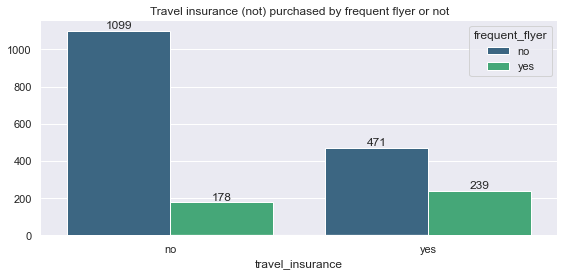

In [67]:
mf.plot_countplot(
    insurance_df,
    'travel_insurance',
    'frequent_flyer',
    'Travel insurance (not) purchased by frequent flyer or not',
)

In [68]:
flyer_perc = mf.make_crosstab_percent(insurance_df, 'frequent_flyer', 'travel_insurance')
flyer_perc

travel_insurance,no,yes
frequent_flyer,,
no,70.00,30.00
yes,42.69,57.31


There we can see stronger relationship between those, who claimed, that are frequent flyers and the purchased travel insurances. More than 57 percent in this group frequent_flyers had a travel insurance with covid-19 coverage, while in the non frequent flyers group - only 30 percent had this insurance. But it must be accounted, that there were only 417 frequent flyers in the whole group of 1987 observations.

### 2.2.8. **ever_travelled_abroad**

In [69]:
insurance_df.ever_travelled_abroad.value_counts()

no     1607
yes     380
Name: ever_travelled_abroad, dtype: int64

There is also only the minority of people, who claimed ever traveled abroad (380 out of 1987). 

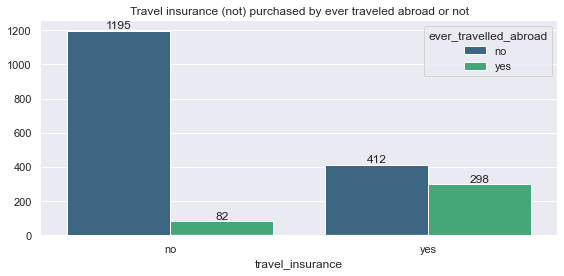

In [70]:
mf.plot_countplot(
    insurance_df,
    'travel_insurance',
    'ever_travelled_abroad',
    'Travel insurance (not) purchased by ever traveled abroad or not',
)

In [71]:
travelers_perc = mf.make_crosstab_percent(insurance_df, 'ever_travelled_abroad', 'travel_insurance')
travelers_perc

travel_insurance,no,yes
ever_travelled_abroad,,
no,74.36,25.64
yes,21.58,78.42


In [72]:
travelers_numbers = mf.make_crosstab_number(insurance_df, 'ever_travelled_abroad', 'travel_insurance')
travelers_numbers

travel_insurance,no,yes
ever_travelled_abroad,,
no,1195,412
yes,82,298


So these, who claimed to travel abroad, are strongly tended to buy travel insurance - more than 78 percent of them bought travel insurance. Let's see is this proportions statistically significant.

* **Inferential statistical analysis:**

In [73]:
table2 = pd.DataFrame(
    {
        'with_insurance': [298 / 380, 412 / 1607],
        'number_of_people': [380, 1607],
        'number_of_insurances': [298, 412],
    },
    index=['traveled', 'not_traveled'],
)
table2

,with_insurance,number_of_people,number_of_insurances
traveled,0.78,380,298
not_traveled,0.26,1607,412


**Research question:**
Is the difference in proportions of people with travel insurance, who had ever traveled abroad and who hadn't, statistically significant?

**Population** All people, who were interviewed.

People, who claimed, they had traveled abroad = 380

People, who claimed they had never traveled abroad = 1607

**Parameter of interest** 
Difference in population proportions: (p(1) - p(2)) -> 0,78 - 0,26 = 0.52
                                      

**Power of the test** ($1 - \beta$) - 0.8 

**Significance level**: 0.05

**Null Hypothesis:** p1 - p2 = 0  (there is no difference)

**Alternative Hypothesis:** p1 - p2 > 0

One tail testing, the difference is >0

**Assumptions**:
1. Our samples are independent from each other (taken from different people, different time).

* Preliminary power test analysis, to get the needed sample size to avoid p-hacking.

In [74]:
effect_size = sms.proportion_effectsize(
    0.78, 0.26
)

required_n = sms.NormalIndPower().solve_power(
    effect_size, power=0.8, alpha=0.05, ratio=1
)  
required_n = ceil(required_n)
print(
    f'Required sample size:{required_n}'
)

Required sample size:14


I have a much larger sample size, so I think p-hacking should be avoided.

* **Calculations**

In [75]:
p_comb = (298+412)/1987  # the mean of all insurances
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / 380 + 1 / 1607))

# Calculate the test statistic and its p-value
test_stat = (0.78 - 0.26) / se
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))
print(f'T-statistics: {test_stat}, p-value: {pvalue}')

T-statistics: 19.02292917138244, p-value: 1.101540146383427e-80


The difference of the proportions of insurance buyers among people, who had traveled abroad and who hadn't is very large - 0.52. The aim was to check is this difference statistically significant, or maybe made by a chance. 
From this observed data we got, that the T -statistics in the difference of two proportions is large 19.02, so our observed difference in sample proportions is 19.02 estimated standard errors above our hypothesized mean (0) of equal population proportions. Based on our sample and our p-value is 1.101540146383427e-80, that is almost equal to 0 and is smaller than our set alpha value of 0.05, we have enough evidence to reject the null hypothesis. 
In this case, we conclude that there is significant difference between the population proportions of insurance buyers among people, who had traveled abroad and who hadn't. 

Let's check the Confidence interval.

**Confidence intervals**

1. Confidence level of 95%.
2. Significant level alpha = 0.05

In [76]:
table2

,with_insurance,number_of_people,number_of_insurances
traveled,0.78,380,298
not_traveled,0.26,1607,412


In [77]:
se_travelers = np.sqrt(0.78* (1 - 0.78) / 380)
se_not_travelers = np.sqrt(0.26 * (1 - 0.26) / 1607)

se_diff = np.sqrt(se_travelers**2 + se_not_travelers**2)

lcb = 0.52- 2*se_diff
ucb = 0.52 + 2*se_diff
print(f'CI in proportion of insurances among people, who travel abroad and not: {lcb, ucb}')

CI in proportion of insurances among people, who travel abroad and not: (0.47219601919284643, 0.5678039808071537)


The 95% confidence interval above shows us that any value for the difference of population proportions is lying between 0.47 and 0.56, this is consistent with the observed data, and our estimated differences were 0.52 (more insurances bought people wth traveling abroad experience), which is in that range. 0 in not in this range, so the null hypothesis was rejected correctly.

Also I want to see how there people claimed to be frequent flyers and traveled abroad together.

In [78]:
mf.make_crosstab_number(insurance_df, 'ever_travelled_abroad', 'frequent_flyer')

frequent_flyer,no,yes
ever_travelled_abroad,,
no,1358,249
yes,212,168


It's an interesting aspect, that even 249 people, who claimed to be frequent flyers, have never traveled abroad. But also having in mind that this data set is from India, probably there may be some domestic flights to travel inside the country. But having other smaller countries in mind, I would think it could be a mistake in answers.

* But in this part I want to add a new feature: 'yes' - when person is a frequent flyer and had traveled abroad, 'no' - if these two features do not match as 'yes'.

In [79]:
def traveler_feature(insurance_df) : 
    if (insurance_df['frequent_flyer'] == 'yes') & (insurance_df['ever_travelled_abroad'] == 'yes') : 
        return 'yes'
    else : 
        return 'no'

insurance_df['traveller'] = insurance_df.apply(lambda x : traveler_feature(x),axis=1)

In [80]:
insurance_df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,annual_income_per_person,traveller
0,31,government sector,yes,400000,6,yes,no,no,no,66666.67,no
1,31,private sector/self employed,yes,1250000,7,no,no,no,no,178571.43,no
2,34,private sector/self employed,yes,500000,4,yes,no,no,yes,125000.00,no
3,28,private sector/self employed,yes,700000,3,yes,no,no,no,233333.33,no
4,28,private sector/self employed,yes,700000,8,yes,yes,no,no,87500.00,no


In [81]:
travelers = mf.make_crosstab_percent(insurance_df, 'traveller', 'travel_insurance')
travelers

travel_insurance,no,yes
traveller,,
no,69.10,30.90
yes,11.90,88.10


Oh, well, so yes, even 88 percent of travelers had the insurance.

## 2.3. Dependencies between variables


But first of all we need to replace categorical (boolean) values with numbers.

In [82]:
insurance_df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,annual_income_per_person,traveller
0,31,government sector,yes,400000,6,yes,no,no,no,66666.67,no
1,31,private sector/self employed,yes,1250000,7,no,no,no,no,178571.43,no
2,34,private sector/self employed,yes,500000,4,yes,no,no,yes,125000.00,no
3,28,private sector/self employed,yes,700000,3,yes,no,no,no,233333.33,no
4,28,private sector/self employed,yes,700000,8,yes,yes,no,no,87500.00,no


In [84]:
insurance_numeric_df = insurance_df.replace(
    to_replace={
        "no": 0,
        "yes": 1,
        "government sector": 0,
        "private sector/self employed": 1,
    }
)

In [85]:
insurance_numeric_df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,annual_income_per_person,traveller
0,31,0,1,400000,6,1,0,0,0,66666.67,0
1,31,1,1,1250000,7,0,0,0,0,178571.43,0
2,34,1,1,500000,4,1,0,0,1,125000.00,0
3,28,1,1,700000,3,1,0,0,0,233333.33,0
4,28,1,1,700000,8,1,1,0,0,87500.00,0


In [86]:
insurance_numeric_df.dtypes

age                           int64
employment_type               int64
graduate_or_not               int64
annual_income                 int64
family_members                int64
chronic_diseases              int64
frequent_flyer                int64
ever_travelled_abroad         int64
travel_insurance              int64
annual_income_per_person    float64
traveller                     int64
dtype: object

Now let's check the correlation between all features.

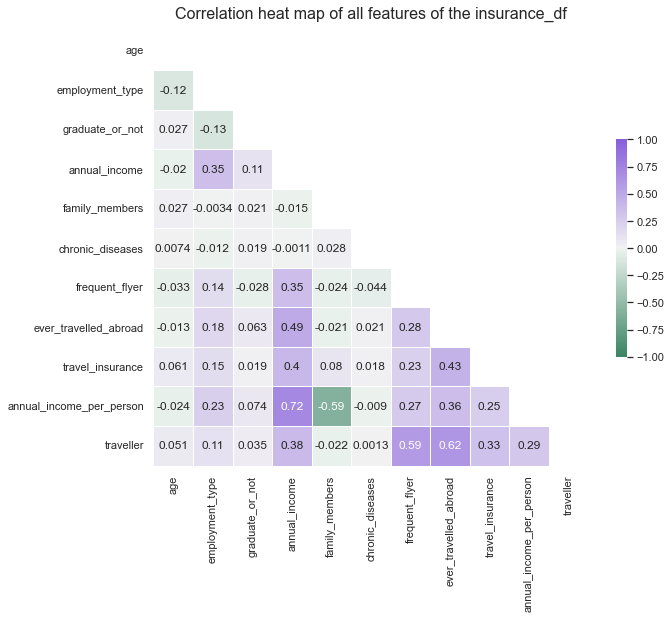

In [87]:
mf.plot_heatmap(insurance_numeric_df, 'Correlation heat map of all features of the insurance_df')

We can see that mostly correlated are:
- target variable - travel_insurance with annual_income, frequent_flyer and ever_traveled_abroad;
- independent features:
as we see my newly made features ('children') has the largest correlation between the 'parent' features, but still they do not exceed 0.8.
But all in all these features aren't totally independent between each other. On the other hand the correlation scores are too (lower than 0.8) small to identify high correlation between them, so that shouldn't cause Multicollinearity in models. I will also check the VIF and conclude some assumptions, related with linear models.

## 2.4. Checking some assumptions for modeling

* *Appropriate outcome type*

The dependent variable from - travel_insurance is a categorical variable with total 2 outcomes: 1 - bought insurance; 0 - did not buy insurance. So we have a binary classification problem (with two possible outcomes). Models to use: classifiers.

* *Sufficiently large sample size*

Total number of observations should be greater than 500 and it is so, total number of observations: 1987. it's not a very big sample size, so we will not have problem with to long performance.

* *Absence of multicollinearity*

There are no multicollinearity bertween independent variables. I assumed that any features with a correlation coefficient exceeding 0.80 are suspected of causing multicollinearity. From EDA in chapter 2.3 and the heatmap of Pearson's correlation coefficients we see that no features, that I will use in modeling, correlation coefficients reach or exceed 0.8. But let's count the VIF:

In [88]:
# Calculating Variance Inflation Factor (VIF)
X_temp = insurance_numeric_df.copy()
X_temp = X_temp.drop(['travel_insurance'], axis=1)
X_temp_constant = add_constant(X_temp)

mf.calc_vif(X_temp_constant) 

,variables,VIF
0,const,149.15
1,age,1.03
2,employment_type,1.19
3,graduate_or_not,1.05
4,annual_income,5.07
5,family_members,3.35
6,chronic_diseases,1.00
7,frequent_flyer,1.69
8,ever_travelled_abroad,1.97
9,annual_income_per_person,6.92


The threshold for VIF is usually 5 (i.e. values above 5 means there may be presence of multicollinearity).
Annual_income and annual_income_per_person 

* *Independence of observations*

All the observations in this data set are independent.

* *No strongly influential outliers*

Most of the data is binary. In other columns no very strong outliers were found.

* *Linear relationship between any continuous independent variables and the logit transformation of the dependent variable*

One of the critical assumptions of logistic regression is that the relationship between the logit (aka log-odds) of the outcome and each continuous independent variable is linear.

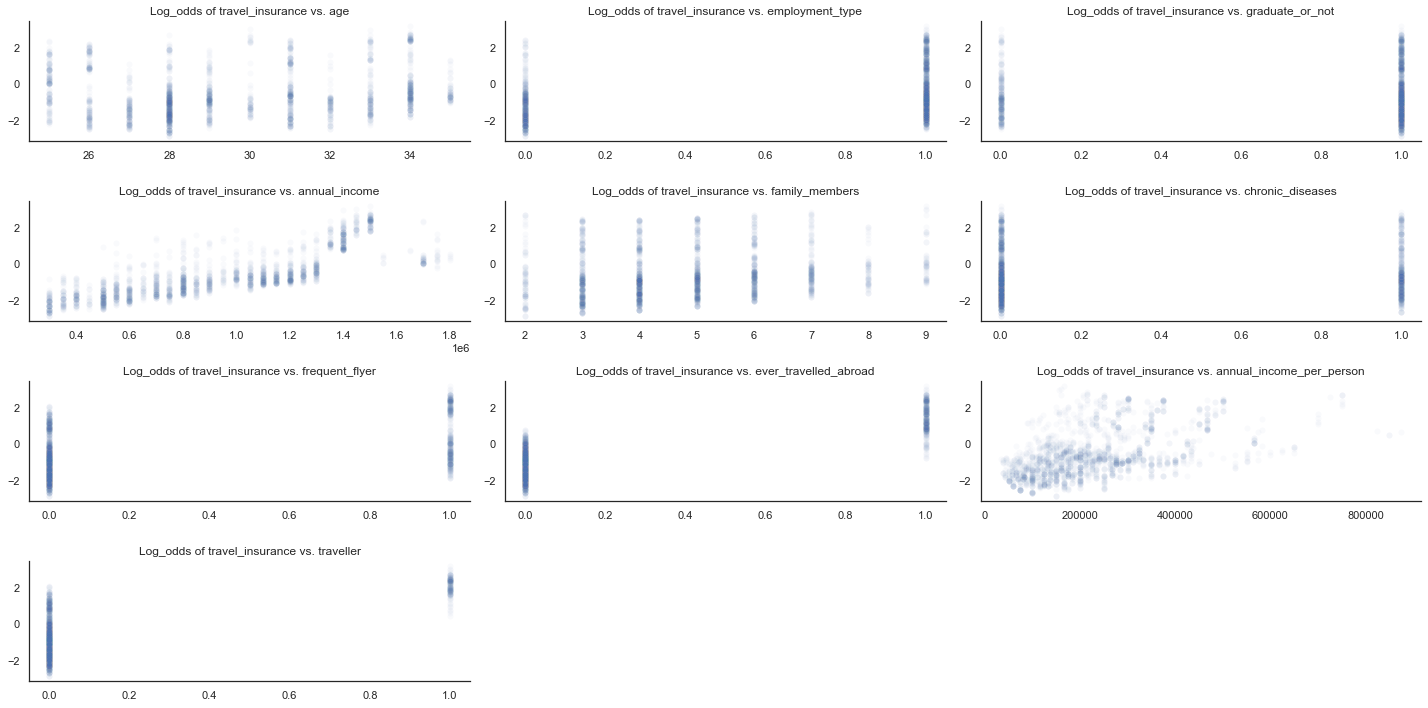

In [89]:
# Re-running logistic regression on the original set of X and y variable

y_temp = insurance_numeric_df.travel_insurance
logit_results = sm.GLM(y_temp, X_temp_constant, family=families.Binomial()).fit()
predicted = logit_results.predict(X_temp_constant)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor variable vs logit values for all columns:
plt.figure(figsize=(20, 10))
cmap = sns.diverging_palette(250, 20, as_cmap=True)

for i in range(1, len(X_temp.columns) + 1):
    plt.subplot(4, 3, i)
    ax = sns.scatterplot(x=X_temp[X_temp.columns[i - 1]].values, y=log_odds, alpha=0.03)
    ax.set_title(f'Log_odds of travel_insurance vs. {X_temp.columns[i-1]}')
    sns.despine(right=True, left=False)
plt.tight_layout()
plt.show()

**Conclusion** Quite clear linear patterns are with annual_income, family_members, frequent_flyer, ever_traveled_abroad, traveler, . Other's, especially with binary outcome, not so clear. Having in mind all other assumptions confirmed, logistic regression, Linear SVM could be tried first.

In [ ]:
insurance_df.to_csv('insurance_df.csv', index=False)

In [ ]:
insurance_numeric_df.to_csv('insurance_numeric_df.csv', index=False)

# Conclusion

* It is an imbalanced data set, as we have data about 1277 people, who did not buy this package of travel insurance with covid-19 coverage, and 710 who did. And from those who didn't we have 511 duplicated instances, so it could be considered to remove them. On the other hand data set ir very small and it will be hard to split it into train/test sets and remove such a large number of values. This step could be considered, if the models will not show good accuracy/recall.

* **Features that matters**:

* Employment type. The difference between proportions of people working in government sector and in private sector, who bought travel insurance, was statistically significant - about 15 percent more insurances were bought by people, working in private sector. Confident interval shows, that there tend to be from 10 to 19 percent more insurance buyers in private sector than in government sector employees. 

* Annual income/Annual income per person - could be one of the best predictors. We can see that people, who tend to buy travel insurance with covid-19 protection have much higher mean of the annual income, the difference is more than 400 000 rupees (than in the group of non buyers). This difference in mean values of annual incomes is statistically significant.

* Frequent flyer - there is a quite strong relationship between those, who claimed, that are frequent flyers and  purchased travel insurances. More than 57 percent in this group of frequent flyers had a travel insurance with covid-19 coverage, while in the non frequent flyers group - only 30 percent had this insurance. But it must be accounted, that there were only 417 frequent flyers in the whole group of 1987 observations.

* Traveled abroad/Traveler - there is significant difference between the population proportions of insurance buyers among people, who had traveled abroad and who hadn't. In the group of travelers abroad even 78 percent of members bought the insurance, while in the non traveler - only 26 percent.

* **Features that doesn't really matter**:

* Age. The age boundaries of respondents are very narrow - from 25 to 25 years. Mostly this covid-19 insurance package was offered to people of age 28 (506 times), then 34 years  - 266 times and 31 years old - 234 times. There are no really strong tendencies that would show larger interest in covid-19 insurance in this age period. 
Data in this data set doesn't cover older people, which are in the risk group of more complicated covid-19 forms and could be more interested in this kind of insurance. 

* Chronic diseases - people with chronic diseases do not look to be more interested in travel insurance with coverage from covid-19. There is only 2 percent increase in the group of people with chronic diseases to buy travel insurance than in the group of healthy (as they claim) people.

* Graduate or not - almost the same percentage of graduates and non graduates tend to buy this insurance - about 34-36 percent. 

* Family members - respondents had from two to nine family members. By percentage more travel insurances were bought by people with larger families (from 6 to 9), where the percentage of purchased insurances varies from 43 to 47 percent, except families of 7 people (37 percent). No really strong patterns can be found by this category.



**Sooo...**

**It looks like a person (not old, younger than 36, so than me ;) with quite large family (from 6 persons), who is a frequent flyer (I don't know with what, maybe with a broom - that you really need with more than 4 kids at home :), who was abroad (counts even once), works in private sector and earns a lot of rupees in India (more than 1,4 million per year, in Euros not so much ;), had graduated college, but has some chronic diseases will probably buy covid-19 insurance :).**